В данной работе мы используем такую библиотеку, как ImageAI - которая, создана для того, чтобы дать разработчикам, исследователям и студентам возможность создавать приложения и системы с автономными возможностями глубокого обучения и компьютерного зрения. С ее помощью можно распозновать объекты на фото с помощью готовых уже обученных моделей. Для работы с данной библиотекой нам также нужно установить такие библиотеки, как tensorflow, opencv-python, keras.

Помимо этого, мы также покажем, как натренировать собственную модель на распознание нужных нам объектов. 

Поскольку в данном проекте мы решили осуществить классификацию пользователей сети Instagram, а именно являютсяли они итровертами или экстравертами, а также, ведут они активный образ жизни или же они приверженцы нездорового образа жизни, то мы будем искать на фото такие объекты, как раздичный спортинвентарь, фаст фуд, бокалы с вином, кондитерские изделия. Для поиска эти объектов мы будем использовать уже обученную модель yolov3, которую вы можете скачать по ссылке
https://github.com/OlafenwaMoses/ImageAI/releases/download/1.0/yolo.h5/

Помимо этого, в наши дни большую популярность набрал кальян, который также является индикатором нездорового образа жизни. Мы будем учить нашу модель находить именно этот объект. 

Прежде всего, для обучения нашей сети нам нужен dataset. Вы можете взять готовый, или же, если такого нет, как в нашем случае, тогда вы можете составить собственный. 

1) Для этого загрузите достаточное (не меньше 100, лучше около 1000 на каждый объект) кол-во фотографий, на которых присутствует ваш объект. Объект на фото должен быть под разными углами и иметь разную освещенность. Также, на некоторых фото объект должен быть частично закрыт. Это нужно для того, что бы нейросеть точнее смогла определить объект на фото. 

2) После сбора фотографий, нужно сделать к ним аннотацию. Мы использовали для этой задачи инструмент labelImg, который вы можете скачать по ссылке 
https://tzutalin.github.io/labelImg/. При помоще этого инструмента вы выделяете на каждом фото ваш объект и указываете его название. 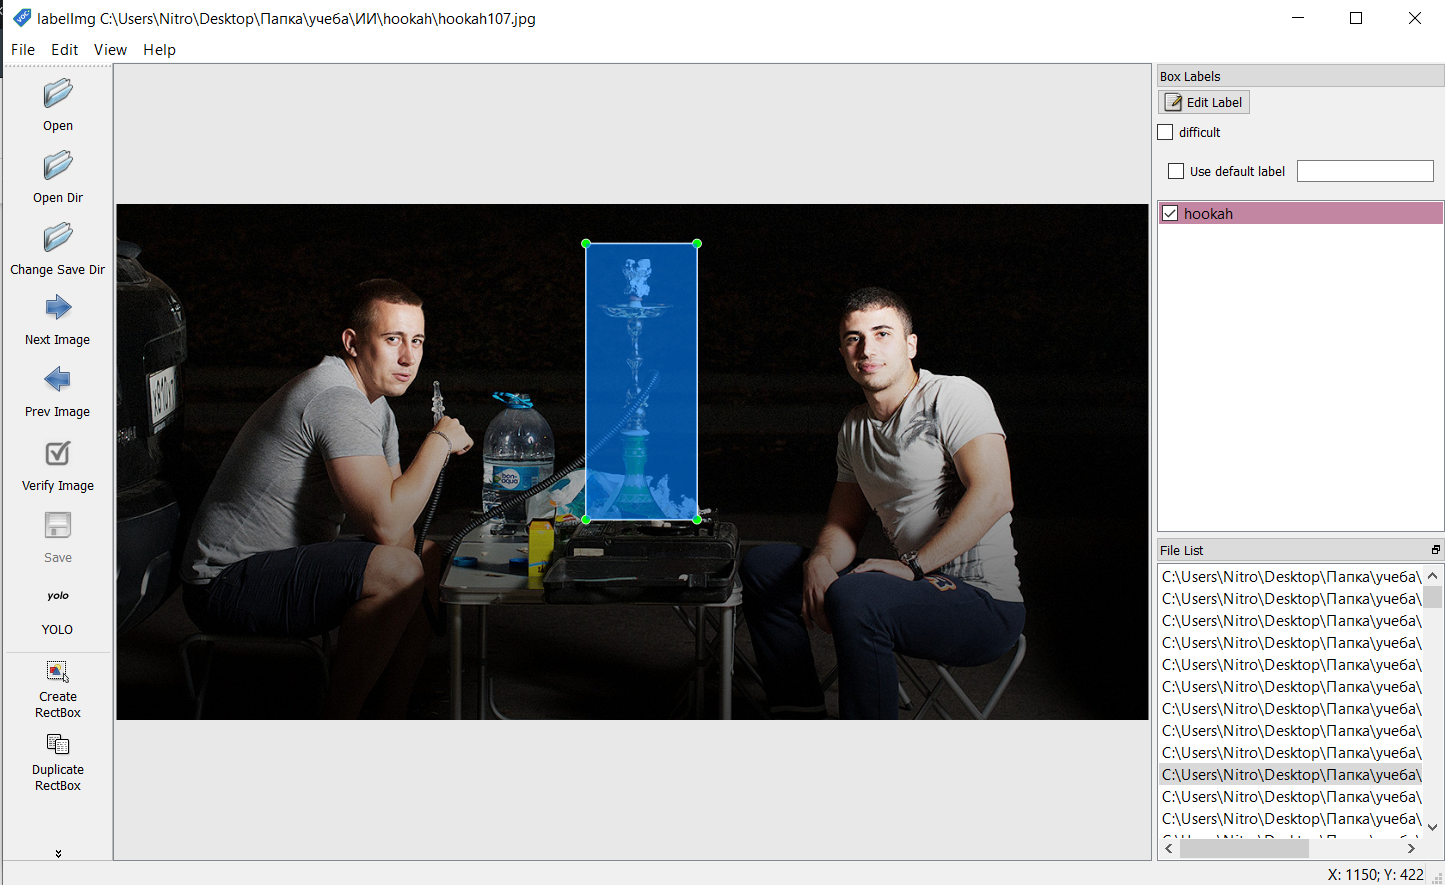

Создать аннотацию вы можете как в формате Pascal VOC, так и в yolo (как в нашем случае). Далее вы архивируете все фото и их аннотации и загружаете на гугл диск для удобства. Теперь мы готовы приступить к обучению нашей сети. 

Мы использовали алгоритм глубокого обучения YOLO “You Only Look Once” (“Стоит только раз взглянуть”), так как в отличие от других алгоритмов сверточной нейронной сети (CNN), используемых для обнаружения объектов, он очень быстро опознает объекты в режиме реального времени. Принцип работы YOLO подразумевает ввод сразу всего изображения, которое проходит через сверточную нейронную сеть только один раз. Именно поэтому он называется “Стоит только раз взглянуть”. В других алгоритмах этот процесс происходит многократно, то есть изображение проходит через CNN снова и снова. Подробнее вы можете узнать о данном алгоритме по ссылке https://arxiv.org/pdf/1506.02640.pdf

In [1]:
!pip install tensorflow
!pip install opencv-python
!pip install keras
!pip install imageAI

     |████████████████████████████████| 160 kB 5.4 MB/s 
     |████████████████████████████████| 2.9 MB 40.7 MB/s 
     |████████████████████████████████| 2.1 MB 36.0 MB/s 
     |████████████████████████████████| 14.9 MB 107 kB/s 
     |████████████████████████████████| 11.6 MB 2.6 MB/s 
  Created wheel for keras-resnet: filename=keras_resnet-0.2.0-py2.py3-none-any.whl size=20486 sha256=deb1cbb36d9fff37a2a3bd81ec794fc7b9379fd167bb9dc04f94aa58311f1e02
  Stored in directory: /root/.cache/pip/wheels/bd/ef/06/5d65f696360436c3a423020c4b7fd8c558c09ef264a0e6c575
Successfully built keras-resnet
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
  Attempting uninstall: pillow
    Found existing installation: Pillow 7.1.2
    Uninstalling Pillow-7.1.2:
   

In [2]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


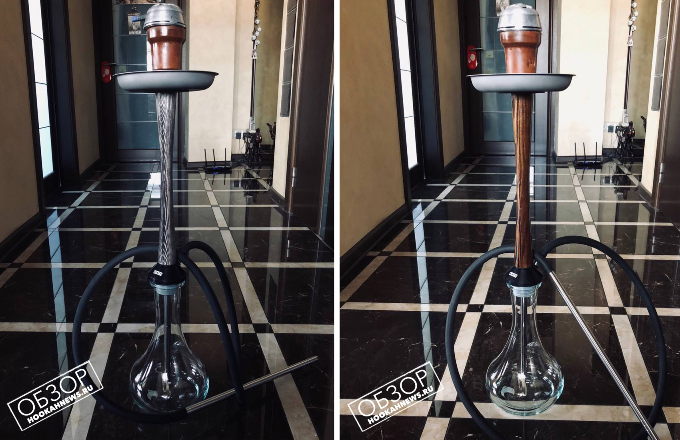

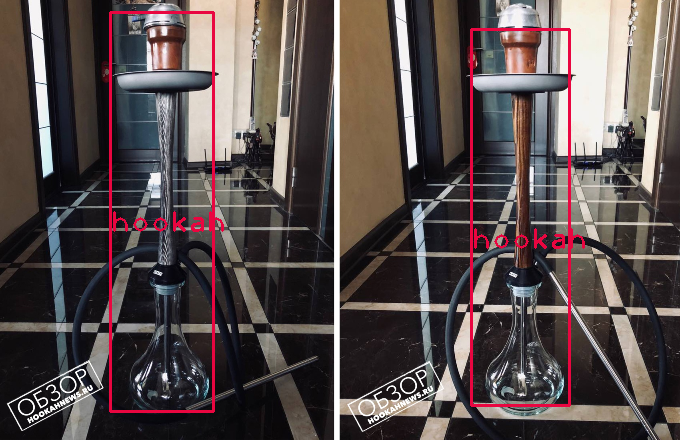

In [3]:
import cv2
from google.colab.patches import cv2_imshow


# Передаем файл с весами и файл конфигурации нашей модели и загружаем ее
net = cv2.dnn.readNet("/content/gdrive/MyDrive/yolov3/yolov3_training_last.weights", "/content/gdrive/MyDrive/yolov3/yolov3_testing.cfg")

# названия классов
classes = ["hookah"]

# 254 слоя всего
layer_names = net.getLayerNames()

# получаем названия выходных слоев
output_layers = [layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]

img_path = "/content/gdrive/MyDrive/yolov3/hookah23.jpg"
img = cv2.imread(img_path)
# fx – коэффициент масштабирования по оси X или по горизонтальной оси; 
#fy – коэффициент масштабирования по оси Y или вертикальной оси;
img = cv2.resize(img, None, fx=0.4, fy=0.4)
cv2_imshow(img)

height, width, channels = img.shape
colour = [64.40020898, 6.36384924, 233.03528776]

# Detecting objects
# кф масштабирования = 1/255
# размер 416 * 416
# скаляр со средними значениями, которые вычитаются из каналов.
# инверсия порядка каналов
# флажок, указывающий, будет ли изображение обрезано после изменения размера или нет
# объект, который является нашим входным изображением после среднего вычитания, нормализации и переключения каналов.
blob = cv2.dnn.blobFromImage(img, 0.00392, (416, 416), (0, 0, 0), swapRB=True, crop=False)


# Эти две инструкции рассчитывают отклик сети
net.setInput(blob)
# вычисленные выходные данные с выходных слоев, которые мы указали
out = net.forward(output_layers)

# Вывод найденных объектов на фото с помощью рамок
confidences = []
boxes = []

for detection in out[0]:
    confidence = detection[5]
    if confidence > 0.6:
        # Object detected
        center_x = int(detection[0] * width)
        center_y = int(detection[1] * height)
        w = int(detection[2] * width)
        h = int(detection[3] * height)

        # Координаты прямоуголька
        x = int(center_x - w / 2)
        y = int(center_y - h / 2)

        boxes.append([x, y, w, h])
        confidences.append(float(confidence))


#score_threshold
# nms_threshold	
indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)
# тип шрифта
font = cv2.FONT_HERSHEY_PLAIN
for i in range(len(boxes)):
    if i in indexes:
        x, y, w, h = boxes[i]
        label = str(classes[0])
        cv2.rectangle(img, (x, y), (x + w, y + h), colour, 2)
        cv2.putText(img, label, (x, y + height//2), font, 2, colour, 2)


cv2_imshow(img)

In [4]:
import os
from imageai.Detection import ObjectDetection
import cv2
from google.colab.patches import cv2_imshow
from google.colab import files
files.upload()

sport_things = ["bicycle", "frisbee", "skis", "snowboard", "kite", 
                "baseball bat", "sports ball", "baseball glove", "skateboard",
                "surfboard", "tennis racket"]
unhealthy_things = ["wine glass", "hot dog", "pizza", "donut", "cake", "beer", "hookah"]
sport_photos = 0
unhealthy_photos = 0
sport = 0
unhealthy = 0
count_people = 0
count_photo_with_crowd = 0
count_photos = 0


net = cv2.dnn.readNet("/content/gdrive/MyDrive/yolov3/yolov3_training_last.weights", "/content/gdrive/MyDrive/yolov3/yolov3_testing.cfg")
classes = ["hookah"]
layer_names = net.getLayerNames()
output_layers = [layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]


detector_main = ObjectDetection()

model_path = "/content/gdrive/MyDrive/yolov3/yolo.h5"

detector_main.setModelTypeAsYOLOv3()
detector_main.setModelPath(model_path)
detector_main.loadModel()

custom = detector_main.CustomObjects(bicycle = True, frisbee = True, skis = True, 
    snowboard = True, kite = True, baseball_bat = True, sports_ball = True,
    baseball_glove = True, skateboard = True, surfboard = True, tennis_racket = True,
    wine_glass = True, hot_dog = True, pizza = True, donut = True, cake = True, person = True)
i = 0
for i_elem in os.listdir(os.path.abspath("/content")):
    if (i_elem.endswith(".jpg")) and not i_elem.startswith("new") :
        count_photos += 1
        input_path = os.path.join("/content", i_elem)
        print(input_path)
        i += 1
        output_path = "/new_image" + str(i) + ".jpg"
        
        detection = detector_main.detectCustomObjectsFromImage(custom_objects = custom, 
                                                  input_image=input_path, 
                                                  output_image_path=output_path, 
                                                  minimum_percentage_probability=30)
        

        # sport = 0
        # count_people = 0
        # unhealthy = 0

        img = cv2.imread(input_path)
        blob = cv2.dnn.blobFromImage(img, 0.00392, (416, 416), (0, 0, 0), swapRB=True, crop=False)
        # Эти две инструкции рассчитывают отклик сети
        net.setInput(blob)
        out = net.forward(output_layers)

        # Showing informations on the screen

        for detect in out[0]:
            # уверенность
            confidence = detect[5]
            if confidence > 0.6:
                unhealthy += 1
                print("unhealthy", unhealthy)
                print("hookah")


        for eachItem in detection:
          if eachItem["name"] == "person":
              count_people += 1
              print("count_people_on_photo =",count_people)
          if eachItem["name"] in unhealthy_things:
              unhealthy += 1
              print("unhealthy", unhealthy)
              print(eachItem["name"])
          elif eachItem["name"] in sport_things:
              sport += 1
              print("sport", sport)
              print(eachItem["name"])
        if sport > 0 and unhealthy == 0:
            sport_photos += 1
            print("sport_photo", sport_photos)
        elif unhealthy > 0:
            unhealthy_photos += 1
            print("unhealthy_photos", unhealthy_photos)
        if count_people > 2:
            count_photo_with_crowd += 1
            print("count_photo_with_crowd = ", count_photo_with_crowd)
        unhealthy = 0
        sport = 0
        count_people = 0
        print("---------------------------------------------------------------")



if count_photo_with_crowd > count_photos // 2:
    if sport_photos > unhealthy_photos:
        print("Данный пользователь - экстроверт и придерживается активного образа жизни", sport_photos, unhealthy_photos)
    elif sport_photos < unhealthy_photos:
        print("Данный пользователь - экстроверт и придерживается нездорового образа жизни", sport_photos, unhealthy_photos)
    else:
        print("Данный пользователь - экстроверт и придерживается веселого образа жизни", sport_photos, unhealthy_photos)
else:
    if sport_photos > unhealthy_photos:
        print("Данный пользователь - интроверт и придерживается активного образа жизни", sport_photos, unhealthy_photos)
    elif sport_photos < unhealthy_photos:
        print("Данный пользователь - интроверт и придерживается нездорового образа жизни", sport_photos, unhealthy_photos)
    else:
        print("Данный пользователь - интроверт и придерживается веселого образа жизни", sport_photos, unhealthy_photos)






Saving 1.jpg to 1.jpg
Saving 2.jpg to 2.jpg
Saving 3.jpg to 3.jpg
Saving 4.jpg to 4.jpg
Saving 5.jpg to 5.jpg
Saving 6.jpg to 6.jpg
Saving 7.jpg to 7.jpg
Saving 8.jpg to 8.jpg
Saving 9.jpg to 9.jpg
Saving 10.jpg to 10.jpg
Saving 11.jpg to 11.jpg
Saving 12.jpg to 12.jpg
Saving 13.jpg to 13.jpg
Saving 14.jpg to 14.jpg
Saving 15.jpg to 15.jpg
Saving 16.jpg to 16.jpg
/content/16.jpg


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: DeprecationWarning: 'detectCustomObjectsFromImage()' function has been deprecated and will be removed in future versions of ImageAI. 
 Kindly use 'detectObjectsFromImage()' 


count_people_on_photo = 1
count_people_on_photo = 2
count_people_on_photo = 3
count_people_on_photo = 4
count_people_on_photo = 5
unhealthy 1
cake
unhealthy_photos 1
count_photo_with_crowd =  1
---------------------------------------------------------------
/content/6.jpg
count_people_on_photo = 1
count_people_on_photo = 2
count_people_on_photo = 3
count_people_on_photo = 4
count_photo_with_crowd =  2
---------------------------------------------------------------
/content/13.jpg
count_people_on_photo = 1
count_people_on_photo = 2
count_people_on_photo = 3
count_people_on_photo = 4
count_people_on_photo = 5
count_photo_with_crowd =  3
---------------------------------------------------------------
/content/11.jpg
unhealthy 1
cake
unhealthy_photos 2
---------------------------------------------------------------
/content/8.jpg
count_people_on_photo = 1
count_people_on_photo = 2
count_people_on_photo = 3
count_people_on_photo = 4
count_photo_with_crowd =  4
------------------------------